# GANs
## Description of the Problem
The goal of this project is to mimic the painting style of Monet when applied to a set of photos.  In order to accomplish this goal a GAN will be used.
A GAN model is based upon two neural networks, a generator model and a discriminator model.

The generator is a neural network whos output is trying to fool the disdriminatory into "believing" that the image style is of a certain style, Monet in the case. The discriminator on the other hand is trying to determine if this image is real or not.  This two Neural Networks compete each other to generate a realistically styled photo, hence the name.


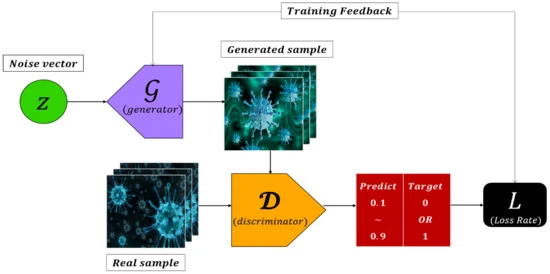

(Source: https://www.mdpi.com/2079-9292/10/10/1216)

The data is from Kaggle and is provided in both jpget and tfrec format.  This GAN model used the tfrec format.



In [3]:
#import all necessary libraries
from kaggle_datasets import KaggleDatasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, ReLU, ZeroPadding2D, GroupNormalization, Concatenate, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import os
%matplotlib inline

2024-03-17 06:39:23.340803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 06:39:23.340893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 06:39:23.461895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Check System Capacity
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu) # Connects to the given cluster
    tf.tpu.experimental.initialize_tpu_system(tpu) # Initializes the TPU system
    strategy = tf.distribute.TPUStrategy(tpu) # TPU distribution strategy
    print('Running with TPUs')

except ValueError:
    print("TPU not available.")
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
        print("Running on GPU.")
    else:
        strategy = tf.distribute.get_strategy()
        print("Running on CPU.")


print("Tensor Flow Version:", tf.__version__)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


TPU not available.
Running on GPU.
Tensor Flow Version: 2.15.0
Your runtime has 33.7 gigabytes of available RAM



## Exploratory data analysis (EDA) 
In the below code the pictures are loaded and reviewed.  A visual inpsection 

In [5]:
## Load the data
GCS_PATH = KaggleDatasets().get_gcs_path()
monet_files= tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('No. of Monet TFRecord files: ',len(monet_files))
photo_files= tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('No. of Photo TFRecord files: ',len(photo_files))

No. of Monet TFRecord files:  5
No. of Photo TFRecord files:  20


In [10]:
# As per competition instructions image size set at 256X256
# Functions necessary to decode the image from jpeg format
# as well as extracting from teh TFRecord format
IMAGE_SIZE= [256,256]                                            

def decode_img(image):                                           
    image= tf.image.decode_jpeg(image,channels= 3)              
    image= (tf.cast(image, tf.float32)/255)*2 -1              
    image= tf.reshape(image, shape= [*IMAGE_SIZE,3])             
    return image

def read_tfrecord(example):                                       
    tfrec_format= {
        'image_name': tf.io.FixedLenFeature([], tf.string),     
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string)
    }
    example= tf.io.parse_single_example(example, tfrec_format)
    image= decode_img(example['image'])
    return image

In [11]:
def load_data(files):
    data= tf.data.TFRecordDataset(files)
    data= data.map(read_tfrecord)                                  
    return data

In [12]:
## Load images as batch sizes of one image
monet_data= load_data(monet_files).batch(1)                   
photo_data= load_data(photo_files).batch(1)

#for development reduce to 10 to speed up...for final version comment out
#monet_data = monet_data.take(10)
#photo_data = photo_data.take(10)


In [13]:
monet_data
# A look at the data confirms image are 256X256X3

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [ ]:
iter_monet = iter(monet_data)
iter_photo = iter(photo_data)


In [ ]:
next_monet= next(iter_monet)
next_photo= next(iter_photo)
plt.figure(figsize = (20,20))
for i in range(4):
    plt.subplot(4, 2, i*2+1)
    plt.imshow(next_photo[0]*0.5 +0.5) 
    plt.title('Photo')
    plt.subplot(4, 2, i*2+2)
    plt.title('Monet')
    plt.imshow(next_monet[0]*0.5 +0.5)
    next_monet= next(iter_monet)
    next_photo= next(iter_photo)

## Model building and training
The first step in building a UNET architecture for a CycleGAN is to build the generators, which includes defining the downsample and upsample methods.  
### Define the Downsample and Upsample functions
Downsample reduces the 2D dimensions of the image by using a stride of 2, reducing in half the height and width.  
 - 2d Convolution - A 2d convultion with stride of two is used to reduce dimensionality.
 - Instance Normalization - In order prevent overfitting and improve the convergence.
 - Leaky ReLU - To prevent the effect of a dying ReLU

Upsample reversed the impact of the downsample doubling the height and width using the Conv2DTranspose
- 2d Transposed Convolution - Reaugment dimensionality.
- Instance Normalization - Only in first three layers, to prevent overfitting and improve the convergence.
- Dropout - To improve the generalization of the model
- ReLU - ReLU activation 

In [ ]:
def downsample(filters, size, instance_norm= True):                                  
    initializer= tf.random_normal_initializer(0,0.02)                                
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    
    model= keras.Sequential()                                          
    model.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer= initializer, use_bias= False))
    
    if instance_norm:
         model.add(GroupNormalization(groups= -1, gamma_initializer= gamma_init))     # groups= -1 to make it work like Instance Normalization
   
    model.add(LeakyReLU())
    
    return model

In [ ]:
def upsample(filters, size, dropout= False):                                         
    initializer= tf.random_normal_initializer(0,0.02)
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    
    model= keras.Sequential()
    model.add(Conv2DTranspose(filters, size, strides= 2, padding= 'same', kernel_initializer= initializer, use_bias= False))
    model.add(GroupNormalization(groups= -1, gamma_initializer= gamma_init))
    
    if dropout:
        model.add(Dropout(0.5))
    
    model.add(ReLU())
    
    return model

### Build the Generator
The generator downsizes the images using the prior functions and the applies then applies upsample using long skip connections. Skip connections help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one.
- Input Layer - The input should have the shape 256x256x3, the size of the images previously defined.
- Down Stack - Eight downsample layers with skip connections to the Up Stack.
- Up Stack - Seven upsample layers
- 2d Transposed Convolution - Used to augment dimensionality and get a 256x256x3 result.

In [ ]:
def generator():
    down_stack= [
        downsample(64,4,False),                 
        downsample(128,4),                      
        downsample(256,4),                     
        downsample(512,4),                     
        downsample(512,4),                     
        downsample(512,4),                     
        downsample(512,4),                     
        downsample(512,4),                      
    ]
    
    up_stack= [
        upsample(512,4,True),                   
        upsample(512,4,True),                  
        upsample(512,4,True),                   
        upsample(512,4),                       
        upsample(256,4),                        
        upsample(128,4),                        
        upsample(64,4)                         
    ]
    
    initializer= tf.random_normal_initializer(0,0.02)
    last_layer= Conv2DTranspose(3, 4, strides= 2, padding= 'same', kernel_initializer= initializer, activation= 'tanh')     # 3 output channels required
    
    i= Input(shape= [256,256,3])                
    x= i
    skips= []
    for down in down_stack:                     
        x= down (x) 
        skips.append(x)                         
        
    skips= reversed(skips[:-1])                
    
    for up, skip in zip(up_stack,skips):        
        x= up (x)
        x= Concatenate() ([x,skip])
        
    x= last_layer(x)                            
    
    model= Model(i,x)
    
    return model

### Build the Discriminator
The discriminator takes an input image and attempts to determine if it is real or generated. THe output of the discriminator is a smaller 2D image indicating the probability of a real classification or fake classification.  The higher the number the higher the likelyhood of real.
- Input Layer - input image of shape 256x256x3
- Down Stack - TApply 3 downsample layers.
- Zero Padding - Fill the boarders of the image with zeros to avoid loosing information on the convolution layer.
- 2d Convolution
- Instance Normalization - Applied on first 3 layers to prevent overfitting.
- Leaky Relu - To prevent a dying ReLU.
- Zero Padding - Fill borders of the image with zeros to avoid loosing information on the convolution layer.
- 2d Convolution - Generates the activation map

In [ ]:
def discriminator():
    i= Input(shape= [256,256,3])
    x= downsample(64,4) (i)                                  
    x= downsample(128,4) (x)                                
    x= downsample(256,4) (x)                               
    
    x= ZeroPadding2D() (x)                                   
    
    initializer= tf.random_normal_initializer(0,0.02)
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    x= Conv2D(512, 4, strides= 1, padding= 'same', kernel_initializer= initializer, use_bias= False) (x)      
    x= GroupNormalization(groups= -1, gamma_initializer= gamma_init) (x)
    x= LeakyReLU() (x)
    
    x= ZeroPadding2D() (x)                                  
    
    x= Conv2D(1, 4, strides= 1, padding= 'same', kernel_initializer= initializer) (x)       
                                                                                        
    model= Model(i,x)                                                                       
    
    return model

In [ ]:
# Initialize the Generators adn Discriminators
monet_generator= generator()                     
monet_discriminator= discriminator()             
photo_generator= generator()                     
photo_discriminator= discriminator()            

### Build the CycleGAN
Build CycleGAN by combining the previously defined architectures and apply a loss functions to adjust the gradients

In [ ]:
class CycleGAN(keras.Model):                       # CycleGAN class inheriting from keras.Model class so that it can use its methods to train, compile etc.
    def __init__(                                  # arguments to be passed in a CycleGAN class object   
        self,
        monet_gen,
        monet_disc,
        photo_gen,
        photo_disc,
        lambda_cycle= 10                           # 'lambda_cycle' controls the importance of cycle consistency loss
    ):
        super(CycleGAN,self).__init__()            # calls the constructor of the parent class (keras.Model), initializing the base properties and methods
        self.m_gen= monet_gen                      # assigning argument values to attributes of a CycleGAN class object/instance
        self.m_disc= monet_disc
        self.p_gen= photo_gen
        self.p_disc= photo_disc
        self.lambda_cycle= lambda_cycle
        
    def compile(                                   
        self,
        m_gen_optimizer,
        m_disc_optimizer,
        p_gen_optimizer,
        p_disc_optimizer,
        gen_loss_function,
        disc_loss_function,
        cycle_loss_function,
        identity_loss_function
    ):
        super(CycleGAN,self).compile()            
        self.m_gen_optimizer = m_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_function = gen_loss_function
        self.disc_loss_function = disc_loss_function
        self.cycle_loss_function = cycle_loss_function
        self.identity_loss_function = identity_loss_function
        
    def train_step(self,batch_data):                                
        real_monet, real_photo= batch_data
        
        with tf.GradientTape(persistent= True) as tape:             
            
            fake_monet= self.m_gen(real_photo, training= True)      
            cycled_photo= self.p_gen(fake_monet, training= True)
            
            fake_photo= self.p_gen(real_monet, training= True)     
            cycled_monet= self.m_gen(fake_photo, training= True)
            
            same_photo= self.p_gen(real_photo, training= True)      
            same_monet= self.m_gen(real_monet, training= True)      
            
            disc_real_photo= self.p_disc(real_photo, training= True)   
            disc_real_monet= self.m_disc(real_monet, training= True)   
            
            disc_fake_photo= self.p_disc(fake_photo, training= True)   
            disc_fake_monet= self.m_disc(fake_monet, training= True)
            
            gen_monet_loss= self.gen_loss_function(disc_fake_monet)    
            gen_photo_loss= self.gen_loss_function(disc_fake_photo)
            
            total_cycle_loss = (self.cycle_loss_function(real_monet, cycled_monet, self.lambda_cycle) +     
            self.cycle_loss_function(real_photo, cycled_photo, self.lambda_cycle))
            
            total_gen_monet_loss= (gen_monet_loss + total_cycle_loss   +                                   
            self.identity_loss_function(real_monet, same_monet, self.lambda_cycle) )  
            
            total_gen_photo_loss= (gen_photo_loss + total_cycle_loss   +                                    
            self.identity_loss_function(real_photo, same_photo, self.lambda_cycle) )
            
            disc_monet_loss= self.disc_loss_function(disc_real_monet, disc_fake_monet)                     
            disc_photo_loss= self.disc_loss_function(disc_real_photo, disc_fake_photo)                      
            
            
        gen_monet_gradients= tape.gradient(total_gen_monet_loss, self.m_gen.trainable_variables)           
        gen_photo_gradients= tape.gradient(total_gen_photo_loss, self.p_gen.trainable_variables)            
        
        disc_monet_gradients= tape.gradient(disc_monet_loss, self.m_disc.trainable_variables)               
        disc_photo_gradients= tape.gradient(disc_photo_loss, self.p_disc.trainable_variables)
        
        self.m_gen_optimizer.apply_gradients(zip(gen_monet_gradients, self.m_gen.trainable_variables))      
        self.p_gen_optimizer.apply_gradients(zip(gen_photo_gradients, self.p_gen.trainable_variables))      
        self.m_disc_optimizer.apply_gradients(zip(disc_monet_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(disc_photo_gradients, self.p_disc.trainable_variables))
        
        return {
            'gen_monet_loss': total_gen_monet_loss,
            'gen_photo_loss': total_gen_photo_loss,
            'disc_monet_loss': disc_monet_loss,
            'disc_photo_loss': disc_photo_loss
        }

### Define the loss function to use
- Using binary crossentropy calculate the real loss
- Using binary crossentropy calculte the generated loss
- Calculate the total loss.
- Normalize through multiplication by .5

In [ ]:
def gen_loss_fn(generated):            # from_logits=True used bcz disc return unbounded values & NONE redn used to return tensor of indiv losses bcz those values are returned at each epoch
    return BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

In [ ]:

def disc_loss_fn(real, generated):
    loss_real= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
    loss_fake= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)
        
    total_loss= (loss_real + loss_fake)/2
        
    return total_loss

In [ ]:
# with strategy.scope():
def cycle_loss_fn(real, cycled, lambda_cycle):
    loss= tf.reduce_mean(tf.abs(real - cycled))
        
    return lambda_cycle*loss                       

In [ ]:
# with strategy.scope():
def identity_loss_fn(real, same, Lambda):           
    loss= tf.reduce_mean(tf.abs(real - same))
        
    return Lambda*loss*0.5                          

### Define the optimizer
Adam optimizer with a beta of .5 and an initial learning rate of 2e-4.

In [ ]:
m_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
m_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

p_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
p_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

## Model building and training

In [ ]:

cyclegan_model= CycleGAN(monet_generator, monet_discriminator, photo_generator, photo_discriminator, 10)
cyclegan_model.compile(m_gen_opt, m_disc_opt, p_gen_opt, p_disc_opt, gen_loss_fn, disc_loss_fn, 
                        cycle_loss_fn, identity_loss_fn)

In [ ]:
cyclegan_model.fit(tf.data.Dataset.zip((monet_data, photo_data)), epochs= 50)

## Result

In [ ]:
fig,ax= plt.subplots(6,2, figsize=(7,20))
for i,img in enumerate(photo_data.take(6)):
    pred= monet_generator(img, training= False)[0].numpy()   # training= False to make sure not to update model's weights
    pred= (pred*127.5 + 127.5).astype(np.uint8)              # making pixel range to [0,255]
    img= (img[0]*127.5 + 127.5).numpy().astype(np.uint8)
    
    ax[i,0].imshow(img)
    ax[i,1].imshow(pred)
    ax[i,0].set_title('Original Photo')
    ax[i,1].set_title('Generated Painting')
    ax[i,0].axis('off')
    ax[i,1].axis('off')

In [ ]:
import PIL
!mkdir ../images

In [ ]:
i = 1
for image in photo_data:
    pred = monet_generator(image, training=False)[0].numpy()
    pred = (pred*127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(pred)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

### Reference:  Model built using frameworkd developed in the below tutorial
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook